In [1]:
import os
import json
import shutil
import lzma
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import scipy
import scipy.sparse as sps
from scipy.sparse import csr_matrix
import scipy.stats as st
from random import shuffle

import networkx as nx
import louvain
import igraph as ig

C:\Users\rdm42\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<ipython-input-1-311869d41af1>:21: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [101]:
def plot_degree_summary(Mwd=None, G=None):
    
    if G is None:
        dw = Mwd.sum(axis=1)
        print(f"Number of words: {Mwd.shape[0]}")
        print(f"Number of documents: {Mwd.shape[1]}")
    else:
        dw = pd.Series(dict(G.degree()))
        print(f"Number of words: {len(G)}")
        

    # Summary analysis of the network:
    gamma = 1 + dw.size/np.log(dw / dw.min()).sum()
    print(f"Network's gamma is {gamma:.2f}")


    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    plt.suptitle("Word degree summary", size=20)

    # Words' degrees

    n = 6
    s = dw.sort_values(ascending=False)
    custom_ticks = [min((s.size//n)*l,s.size-1) for l in range(n+1)]
    custom_labels = s.index[custom_ticks]

    axs[0].set_title("Degrees", size=16)
    axs[0].set_ylabel("Word count across documents", size=12)
    axs[0].semilogy(s)
    axs[0].set_xticks(custom_ticks)
    axs[0].set_xticklabels(custom_labels, rotation=30)


    # Words degree distribution

    k = np.unique(dw)
    pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
    pk = pk/pk.sum()
    # Pk = 1-np.cumsum(pk)
    p_ideal = ((gamma-1)/k.min()) * ((k/k.min())**(-gamma))

    label = r'$\gamma$' + f" = {gamma:.2f}\n" + r'$k_{min}$' + f" = {k.min()}"
    axs[1].loglog(k, pk, 'o')
    axs[1].loglog(k, p_ideal,label=label)
    axs[1].set_title("Distribution", size=16)
    axs[1].set_xlabel("k", size=12)
    axs[1].set_ylabel("$p_k$", size=12)
    axs[1].legend(loc='upper right')

    plt.tight_layout()
    
    return gamma, fig, axs

In [3]:
def clean_Mwd_matrix(Mwd,words,documents,thresh=2):

    # remove elements that are too central, e.g., #covid19
    not_wanted = Mwd.sum(axis=1) > Mwd.shape[1]/4
    text = "removing: " + ", ".join(words[not_wanted])
    words = words[~not_wanted]
    Mwd = Mwd[~not_wanted,:]

    # remove documents and words with fewer than 2 links
    while True:
        dim_old = Mwd.size
        
        # remove documents with less than 2 words
        wanted = Mwd.sum(axis=0) >= thresh
        Mwd = Mwd[:,wanted]
        documents = documents[wanted]

        # remove words in less than 2 documents
        wanted = Mwd.sum(axis=1) >= thresh
        text = text + ", " + ", ".join(words[~wanted])
        words = words[wanted]
        Mwd = Mwd[wanted,:]
        
        # exit criterion
        if (dim_old == Mwd.size): break

    print(text)
    return Mwd, words, documents

def logg(x):
    y = np.log(x)
    y[x==0] = 0
    return y



def probability_matrices(Mwd, equalik = True, tform = False):

    if equalik: # documents equally likely
        Pwd = Mwd/Mwd.sum(axis=0) / Mwd.shape[1]
        
    else: # documents proportional to their length
        Pwd = Mwd / Mwd.sum()
        
    # TF-IDF format
    if (tform):
        iw = -logg(np.sum(Mwd>0,axis=1)/Mwd.shape[1])
        Pwd = sps.diags(np.array(iw)[0]).dot(Pwd) # TF-IDF form
        Pwd = Pwd/Pwd.sum() # normalize, treat it as Pwd
        
    
    
    # Creo que aquí debe ser .dot ..............
    
    # words and document matrices
    pd = Pwd.sum(axis=0)
    Pww = (Pwd/pd).dot(Pwd.T)
    
    pw = Pwd.sum(axis=1)
    Pdd = (Pwd.T/pw).dot(Pwd)
    
    
    # joint words and document matrix - documents first
    Paa = sps.hstack((sps.csr_matrix((Pwd.shape[1],Pwd.shape[1])),Pwd.T))
    Paa = sps.vstack((Paa,sps.hstack((Pwd,sps.csr_matrix((Pwd.shape[0],Pwd.shape[0]))))))
    Paa = Paa/2.0
    
    return Pwd, Pww, Pdd, Paa

In [4]:
def my_soft_louvain(A, C_start=None, seed=42):
    """
    Find the best partition of a graph using the Louvain Community Detection
    Algorithm.

    References
    [1] Blondel, V.D. et al. Fast unfolding of communities in large networks.
        J. Stat. Mech 10008, 1-12(2008).
        https://doi.org/10.1088/1742-5468/2008/10/P10008
    [2] Traag, V.A., Waltman, L. & van Eck, N.J. From Louvain to Leiden:
        guaranteeing well-connected communities. Sci Rep 9, 5233 (2019).
        https://doi.org/10.1038/s41598-019-41695-z
    [3] Nicolas Dugué, Anthony Perez. Directed Louvain : maximizing modularity
        in directed networks. [Research Report] Université d’Orléans. 2015.
        hal-01231784. https://hal.archives-ouvertes.fr/hal-01231784
    """

    np.random.seed(seed)
    
    # normalize matrix - otherwise it doesn't work -  read by rows
    A = sps.csr_matrix(A)/A.sum()
    
    # initialize the community assignment matrix to "each node is a community"
    C = sps.csr_matrix(sps.identity(A.shape[0], dtype='float'))
    
    # starting assignment
    if C_start is None:
        C_start = sps.csr_matrix(sps.identity(A.shape[0], dtype='float'))

    
    # main loop for the different layers of Louvain
    while True:
        # improve modularity in this layer
        Clayer, improvement = _my_one_level(A,C_start)
        
        if not improvement: break
        
        # Update variables according to the new clusters
        C = C*Clayer
        A = Clayer.T*(A*Clayer)
        
        # initialize the community assignment matrix to "each node is a community"
        C_start = sps.csr_matrix(sps.identity(A.shape[0], dtype='float'))

    # return community assignments and resulting adjacency matrix
    Q = modularity_function(A)
    return C, A, Q


def _my_one_level(A,C):

    N = A.shape[0] # number of nodes
    rand_nodes = list(range(N)) # random nodes list
    shuffle(rand_nodes) # shuffle random nodes list

    d_in = A.sum(axis=1).T # input degrees - row vector
    d_out = A.sum(axis=0) # output degrees - row vector
    A = A + A.T # sum easily accessible by row

    # main loop - loop until you do not see any improvement
    improvement = False
    while True:

        # counter for the number of nodes changing community
        nb_moves = 0
        
        # test each node
        for i in rand_nodes:
            # get the community of node i
            ci_old = C[i,0:C.shape[1]].toarray()[0]
            
            # modify C for our purposes, i.e., exclude node i
            C[i,0:C.shape[1]] = 0
            
            # build vector v for evaluating modularity increase
            v = ( A[i] - d_out[0,i]*d_in - d_in[0,i]*d_out )/2
            
            # find the maximum - best community
            ci = soft_assign(v[0,i], np.array(v*C)[0])
            
            # update matrix
            C[i,0:C.shape[1]] = ci
            
            # update counter (if needed)
            nb_moves += np.linalg.norm(ci-ci_old)

#         print(nb_moves)
        # exit if no improvement
        if (nb_moves<1e-10): break
        
        # otherwise: remove empty communities
        C = C[:,np.unique(scipy.sparse.find(C)[1])]
        
        # set improvement and reshuffle nodes for next try
        improvement = True
        shuffle(rand_nodes)

    # exit
    return C, improvement


def soft_assign(a,v):
    if (a>=0):
        u = np.array(v.data)
        n = np.where(u==u.max())[0][0]
        u = np.zeros(u.shape)
        u[n] = 1
        return np.array(u)/u.sum()

    else:
        u = -np.array(v.data)/a
        g = np.sort(u)[::-1]
        z = np.cumsum(g)-np.append(np.array(range(1,len(g)))*g[1:len(g)],-np.Inf)
        n = np.where(z>=1)[0][0]
        la = ((g[0:n+1]).sum()-1)/(n+1)
        u = u-la
        u[u<0] = 0
        return np.array(u)/u.sum()

In [5]:
def nmi_function(A): # A = Pwc
    aw = A.sum(axis=1).flatten() # word probability
    ac = A.sum(axis=0).flatten() # class probability
    Hc = np.multiply(ac,-logg(ac)).sum() # class entropy
    A2 = ((A/ac).T/aw).T
    A2.data = logg(A2.data)
    y = (A.multiply(A2)).sum()/Hc
    return y


# RDM: Why? How?
def modularity_function(A):
    y = A.diagonal().sum()-(A.sum(axis=0)*A.sum(axis=1)).item()
    return y

def ncut_function(A):
    y = ((A.sum(axis=0)-A.diagonal())/A.sum(axis=0)).mean()
    return y

def my_pagerank(M,q,c=.85,it=60):
    r = q.copy() # ranking matrix, initialized to q (copy)
    for k in range(it): # slow cycle
        r = c*M.dot(r) + (1-c)*q
    return r

def infomap_function(v):
    y = -(v.data*logg(v.data/v.sum())).sum()
    return y

def infomap_rank(Pdd):
    # transition matrix
    pd = Pdd.sum(axis=0).flatten()
    M = sps.csr_matrix(Pdd/pd)
    # pagerank vector - faster than r = my_pagerank(M,q)
    G = ig.Graph.Adjacency((M > 0).toarray().tolist())
    G.es['weight'] = np.array(M[M.nonzero()])[0]
    r = G.pagerank(weights='weight')
    r = (sps.csr_matrix(np.array(r))).T

    return r

def infomap(C,Pdd,r):
    pd = Pdd.sum(axis=0).flatten()
    M = Pdd/pd # transition matrix
    # extract vectors
    z = C.T*sps.diags(r.toarray().flatten())
    q = sps.csr_matrix((1,z.shape[0]))
    c = .85
    for i in range(z.shape[0]):
        tmp = (C[:,i].transpose()*M)*z[i].transpose()
        q[0,i] = (1-(1-c)*C[:,i].sum()/M.shape[0])*z[i].sum()-c*tmp[0,0]
    # extract statistics
    y = infomap_function(q)
    for i in range(z.shape[0]):
        y += infomap_function(sps.hstack([z[i],sps.csr_matrix([[q[0,i]]])]))
    # normalize
    y = (y/infomap_function(pd))-1

    return y


# RDM: What if I'd like to use the Pww instead?
def clustering_statistics(C,Pwd,Pdd,r):

    Pwc = Pwd*C # joint word + class probability
    NMI = nmi_function(Pwc)
    Pcc = C.T*Pdd*C # joint class + class probability
    Q = modularity_function(Pcc)
    Ncut = ncut_function(Pcc)
    Infomap = infomap(C,Pdd,r)

    return [NMI, Q, Ncut, Infomap]

# Reading metadata

In [6]:
download_dir = os.path.join('..','0_data','downloaded_posts')
metadata_paths = [os.path.join(download_dir,f) for f in os.listdir(download_dir) if f.endswith('.json.xz')]

In [7]:
additional_data = []

for i,path in enumerate(metadata_paths):

    with lzma.open(path, 'rt') as file:
        data_dict = json.load(file)
    
    short = data_dict['node']['shortcode']
    user  = data_dict['node']['owner']['username']
    likes = data_dict['node']['edge_media_preview_like']['count']
#     caption = data_dict['node']['edge_media_to_caption']['edges'][0]['node']['text']
#     long = f"{os.path.split(path)[-1].split('.')[0]}.jpg"

    additional_data.append((short,user,likes))#,caption,long))

additional_data = pd.DataFrame(additional_data, columns=['Short','user','likes'])#,'caption','Long'])

additional_data.head(3)

,Short,user,likes
0,fNO52Nxluy,amenstyle,61
1,lzQl_gRlnD,amenstyle,374
2,mrzAb-Rlkt,amenstyle,175


# Reading clean data

In [8]:
captions_path = os.path.join('..','0_data','text_clean.xlsx')
s = ' '

text_col = 'clean_caption'
# text_col = 'clean_all'
# text_col = 'clean_autocaption'

with pd.ExcelFile(captions_path) as xl:
    data = xl.parse(index_col=0) \
             .merge(additional_data, on='Short', how='left', validate='m:1') \
             .drop_duplicates() \
             .reset_index(drop=True)

# Inclusion of username in captions
for col in ['clean_caption','clean_autocaption','clean_all']:
    data[col] = data['user'] + ' ' + data[col]

# collection of words
words = np.unique([token
                   for tokens in data.dropna(subset=[text_col])[text_col].str.split()
                   for token in tokens])

documents = data[text_col].values

# words dictionary
words_dict = {wrd:i for i,wrd in enumerate(words)}

# Occurrence matrix $M_{wd}$

In [9]:
# occurrence matrix for words
Mwd = csr_matrix((len(words_dict), data.shape[0]), dtype = np.int8).toarray()

for j,doc in data[text_col].dropna().items():
    for token in doc.split():
        Mwd[words_dict[token],j] += 1
        
        
# remove words that are used once or twice
select = Mwd.sum(axis=1) > 2
Mwd = Mwd[select,:]
words = words[select]

# remove documents that do not contain words
select = Mwd.sum(axis=0) > 0
Mwd = Mwd[:,select]
documents = documents[select]

# Further cleaning and probability matrices computation
Mwd, words, documents = clean_Mwd_matrix(Mwd,words,documents,thresh=2)
Pwd, Pww, Pdd, Paa = probability_matrices(Mwd, tform=False)

removing: , , 


Number of words: 302
Number of documents: 233
Network's gamma is 2.06


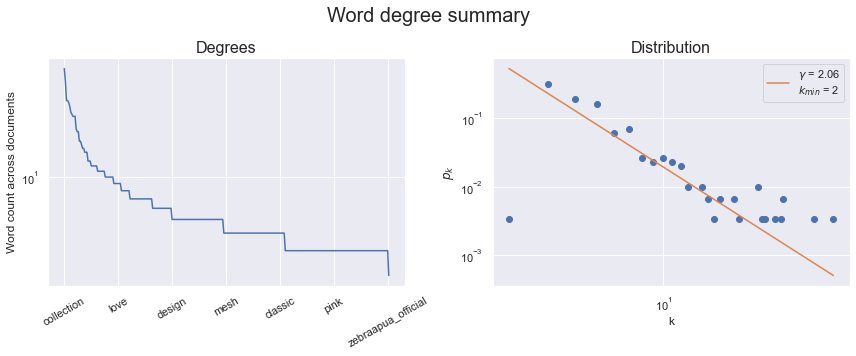

In [10]:
Mwd_df = pd.DataFrame(Mwd,index=words,columns=documents)
Pww_df = pd.DataFrame(Pww,index=words,columns=words)

gamma, fig, axs = plot_degree_summary(Mwd_df)

# Objectification rate per word

,Id,obj_rate
0,accessory,1.00
1,aesthetic,0.50
2,all,0.75


,count,mean,std,min,25%,50%,75%,max
obj_rate,302.0,0.560841,0.311861,0.0,0.333333,0.636364,0.8,1.0


<Axes: xlabel='obj_rate', ylabel='Density'>

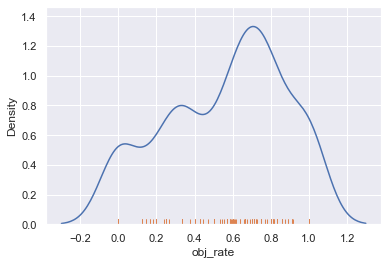

In [11]:
obj_docs = data.set_index(text_col) \
               .query("Objectify==1") \
               .index.drop_duplicates() \
               .intersection(Mwd_df.columns)


# Objectification rate for each word catalogue
# obj_rate = times the word is used in an objectifying post / times the word is used
obj_rate_cat = (Mwd_df[obj_docs].sum(axis=1) / Mwd_df.sum(axis=1)) \
               .to_frame().rename(columns={0:'obj_rate'}) \
               .reset_index(names='Id')

display(obj_rate_cat.head(3))
display(obj_rate_cat.describe().T)


sns.kdeplot(data=obj_rate_cat, x='obj_rate')
sns.rugplot(data=obj_rate_cat, x='obj_rate')

### La distribución luce multimodal

In [12]:
links = Pww_df.melt(ignore_index=False, var_name='Target', value_name='Weight') \
              .reset_index() \
              .rename(columns={'index':'Source'})

links['temp_key'] = links.apply(lambda row: ''.join(sorted([row['Source'],row['Target']])),axis=1)

links.groupby('temp_key')['Weight'].std().unique()

array([           nan, 0.00000000e+00, 1.69406589e-21, 1.35525272e-20,
       8.47032947e-22, 5.42101086e-20, 3.38813179e-21, 6.77626358e-21,
       7.66646708e-20, 2.71050543e-20, 1.53329342e-19])

,count,mean,std,min,25%,50%,75%,max
Weight,6764.0,0.000089,0.000374,0.000001,0.000012,0.000025,0.000067,0.018871


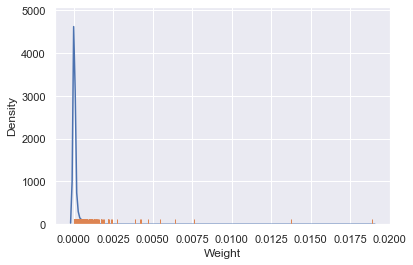

In [13]:
links = Pww_df.where((np.triu(np.ones(Pww_df.shape))).astype(np.bool_)) \
              .melt(ignore_index=False, var_name='Target', value_name='Weight') \
              .dropna() \
              .query("""Weight !=0""") \
              .reset_index() \
              .rename(columns={'index':'Source'})

sns.kdeplot(data=links, x='Weight')
sns.rugplot(data=links, x='Weight')
links.describe().T

In [14]:
tol = links.Weight.quantile(0.05)*0
data_gephi = links.query("Weight >= @tol").sort_values('Weight')

Number of words: 302
Network's gamma is 1.55


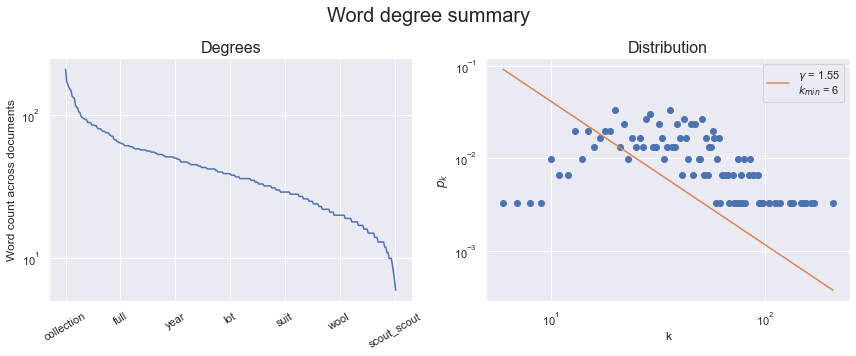

In [15]:
G = nx.from_pandas_edgelist(data_gephi, 'Source', 'Target', ['Weight'])
dw = pd.Series(dict(G.degree()))
_=plot_degree_summary(G=G)

In [16]:
data_gephi.to_csv(f'data/processed/col_{text_col}__tol_{tol}__links.csv',
                  encoding='UTF-16',index=False)

pd.concat([data_gephi.Source,
           data_gephi.Target],
          ignore_index=True) \
  .drop_duplicates() \
  .sort_values() \
  .to_frame(name='Id') \
  .eval("Label=Id") \
  .merge(obj_rate_cat,how='left',on='Id',validate='m:1') \
  .to_csv(f'data/processed/col_{text_col}__tol_{tol}__nodes.csv',encoding='UTF-16',index=False)

# Homophily / Assortativity analysis

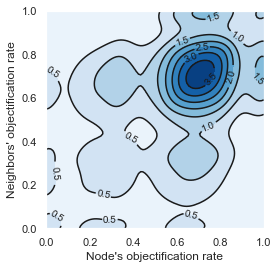

In [18]:
# RDM: Esto hay que hacerlo función para poder cambiar la variable numérica
#      que se use para mostrar

# RDM: Proceso muy lento

# RDM: Consultar con profesor si la implementación es correcta

# ----------------------------------------------------------------------

assortativity_var = 'obj_rate'


cat = obj_rate_cat.set_index('Id')[assortativity_var]

assortativity = [(cat[i],cat[j])
                  for i in G
                    for j in G.neighbors(i)]

assortativity = pd.DataFrame(assortativity, columns=['node_val','neighbors_val'])

# ---------------------------------------------------------------------

data = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
x = assortativity['node_val']
y = assortativity['neighbors_val']
xmin, xmax = 0,1
ymin, ymax = 0,1

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel("Node's objectification rate")
ax.set_ylabel("Neighbors' objectification rate")
ax.set_aspect('equal', adjustable='box')

# Community assignment

## Louvain

In [19]:
# build a graph based on Pdd as adjacency matrix
A = sps.csr_matrix(Pww)
G = ig.Graph.Adjacency((A > 0).toarray().tolist())
G.es['weight'] = np.array(A[A.nonzero()])[0]

In [20]:
# run Louvain on the graph to get a partition
part = louvain.find_partition(G, louvain.ModularityVertexPartition,
                                 weights='weight')

In [21]:
# function to map the partition into a community assignment matrix C
# where rows represent documents, and columns represent topics
def partition_to_C(part):
    
    # RDM: Isn't this matrix transposed?
    C = sps.csr_matrix((Pww.shape[0],len(part)))
    for community,nodes in enumerate(part):
        C[np.array(nodes), community] = 1
    return C

# map the partition into a community assignment matrix C
C_l = partition_to_C(part)

C:\Users\rdm42\anaconda3\lib\site-packages\scipy\sparse\_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [78]:
# Check: cada nodo está asignado a una comunidad
pd.DataFrame(C_l.toarray()).sum(axis=1).eq(1).all() 

True

## Soft Louvain

In [63]:
# refine with soft Louvain

# RDM: Hay que poner .copy, de otra manera la función
#      afecta a las variables globales

with warnings.catch_warnings(record=True) as w:
    C_sl, _A, _Q = my_soft_louvain(Pww.copy(), C_l.copy(),seed=100)
    
C_sl.shape

(302, 10)

In [77]:
# Hacer algoritmos que ya tiene Erseghe

# Hacer BigCLAM

# Calcular métricas de este y el resto de algoritmos!
# usar función de Erseghe


# Guardar asignación de cada algoritmo en diccionario,
# luego usar para calcular NMI (PREGUNTAR A ERSEGHE SI LO VE BIEN)


# Asignar cluster de vuelta a los nodos, visualizaciones en Gephi

# Infomap

In [103]:
def infomap_function(v):
    y = -(v.data*logg(v.data/v.sum())).sum()
    return y

def infomap_rank(Pdd):
    # transition matrix
    pd = Pdd.sum(axis=0).flatten()
    M = sps.csr_matrix(Pdd/pd)
    
    # pagerank vector - faster than r = my_pagerank(M,q)
    G = ig.Graph.Adjacency((M > 0).toarray().tolist())
    G.es['weight'] = np.array(M[M.nonzero()])[0]
    r = G.pagerank(weights='weight')
    r = (sps.csr_matrix(np.array(r))).T

    return r

def infomap(C,Pdd,r):
    pd = Pdd.sum(axis=0).flatten()
    M = Pdd/pd # transition matrix
    
    # extract vectors
    z = C.T*sps.diags(r.toarray().flatten())
    q = sps.csr_matrix((1,z.shape[0]))
    c = 0.85
    
    for i in range(z.shape[0]):
        tmp = (C[:,i].transpose() * M) * z[i].transpose()
        q[0,i] = (1 - (1-c)*C[:,i].sum()/M.shape[0]) * z[i].sum() - c*tmp[0,0]
    
    # extract statistics
    y = infomap_function(q)
    
    for i in range(z.shape[0]):
        y += infomap_function(sps.hstack([z[i],sps.csr_matrix([[q[0,i]]])]))
    
    # normalize
    y = (y/infomap_function(pd))-1

    return y

In [132]:
clusters = G.community_infomap(edge_weights=G.es["weight"])
C_im = partition_to_C(clusters)

In [144]:
r = infomap_rank(Pww)
pd.Series(r.A.flatten(),index=words).sort_values()

jacquemus    0.001733
bershka      0.001763
pick         0.001897
girl         0.001934
summer       0.001943
               ...   
quilt        0.005928
tote         0.005953
athena       0.005953
gilet        0.006593
boot         0.006593
Length: 302, dtype: float64

In [140]:
with warnings.catch_warnings(record=True) as w:
    infomap_score = infomap(C_im,Pww,r)
    
print(f"Infomap score: {infomap_score:,.2f}")
print(f"Modularity: {G.modularity(clusters):.2%}")

Infomap score: 0.05
Modularity: 15.96%


# BertTopic

In [ ]:
# Revisar código del profe
# Preguntar a Daniel por su ejemplo de cómo usarlo

# BigCLAM